<a href="https://colab.research.google.com/github/infox182/Document-Classification/blob/master/Task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Данные

Данные в [архиве](https://drive.google.com/file/d/15o7fdxTgndoy6K-e7g8g1M2-bOOwqZPl/view?usp=sharing). В нём два файла:
- `news_train.txt` тренировочное множество
- `news_test.txt` тренировочное множество

С некоторых новостных сайтов были загружены тексты новостей за период  несколько лет, причем каждая новость принаделжит к какой-то рубрике: `science`, `style`, `culture`, `life`, `economics`, `business`, `travel`, `forces`, `media`, `sport`.

В каждой строке файла содержится метка рубрики, заголовок новостной статьи и сам текст статьи, например:

>    **sport**&nbsp;&lt;tab&gt;&nbsp;**Сборная Канады по хоккею разгромила чехов**&nbsp;&lt;tab&gt;&nbsp;**Сборная Канады по хоккею крупно об...**

# Задача

1. Обработать данные, получив для каждого текста набор токенов
Обработать токены с помощью (один вариант из трех):
    - pymorphy2
    - русского [snowball стеммера](https://www.nltk.org/howto/stem.html)
    - [SentencePiece](https://github.com/google/sentencepiece) или [Huggingface Tokenizers](https://github.com/huggingface/tokenizers)
    
    
2. Обучить word embeddings (fastText, word2vec, gloVe) на тренировочных данных. Можно использовать [gensim](https://radimrehurek.com/gensim/models/word2vec.html) . Продемонстрировать семантические ассоциации. 

3. Реализовать алгоритм классификации, посчитать точноть на тестовых данных, подобрать гиперпараметры. Метод векторизации выбрать произвольно - можно использовать $tf-idf$ с понижением размерности (см. scikit-learn), можно использовать обученные на предыдущем шаге векторные представления, можно использовать [предобученные модели](https://rusvectores.org/ru/models/). Имейте ввиду, что простое "усреднение" токенов в тексте скорее всего не даст положительных результатов. Нужно реализовать два алгоритмов из трех:
     - SVM
     - наивный байесовский классификатор
     - логистическая регрессия
    

4.* Реализуйте классификацию с помощью нейросетевых моделей. Например [RuBERT](http://docs.deeppavlov.ai/en/master/features/models/bert.html) или [ELMo](https://rusvectores.org/ru/models/).

lines = list(open('./news_train.txt', 'r', encoding='utf-8'))

In [ ]:
import nltk
!pip install pymorphy2
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
import random
import numpy as np
import pandas as pd
import pymorphy2
import re
import string
from collections import Counter
from nltk.stem.snowball import RussianStemmer 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim

In [ ]:
# train_df = pd.read_table('../data/news/news_train.txt',header=None,names = ['label','head','text'])
# test_df = pd.read_table('../data/news/news_test.txt',header=None,names = ['label','head','text'])
train_df = pd.read_table('/content/drive/MyDrive/Colab Notebooks/CL_DOC/news/news_train.txt',header=None,names = ['label','head','text'])
test_df = pd.read_table('/content/drive/MyDrive/Colab Notebooks/CL_DOC/news/news_test.txt',header=None,names = ['label','head','text'])

In [ ]:
train_df.head()

,label,head,text
0,sport,Овечкин пожертвовал детской хоккейной школе ав...,Нападающий «Вашингтон Кэпиталз» Александр Овеч...
1,culture,Рекордно дорогую статую майя признали подделкой,"Власти Мексики объявили подделкой статую майя,..."
2,science,Samsung представила флагман в защищенном корпусе,Южнокорейская Samsung анонсировала защищенную ...
3,sport,С футболиста «Спартака» сняли четырехматчевую ...,Контрольно-дисциплинарный комитет (КДК) РФС сн...
4,media,Hopes & Fears объединится с The Village,Интернет-издание Hopes & Fears объявило о свое...


In [ ]:
train_df.groupby('label').count()['head']

label
business      554
culture      2053
economics    2080
forces       1225
life         2033
media        2111
science      2156
sport        2215
style         284
travel        289
Name: head, dtype: int64

In [ ]:
morph = pymorphy2.MorphAnalyzer()
SW = stopwords.words('russian')
SW.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...'])
PU = string.punctuation
PU += '«»–—``''""'
PU += "''"
def tokenize_and_clean(text):
    text_tokens = []
    text = text.replace('.','. ')
    for sent in sent_tokenize(text, 'russian'):
        tokens = word_tokenize(sent)
        for token in tokens:
            token = morph.parse(token.lower())[0].normal_form
            if (re.match(r'[а-я]',token) is not None) and (len(token)>=3)\
                and (token not in SW) and (token not in PU):
                text_tokens.append(token)
    return text_tokens

In [ ]:
test_texts = list(test_df['text'])
test_labels = list(test_df['label'])
train_texts = list(train_df['text'])
train_labels = list(train_df['label'])

In [ ]:
test_tokenize_texts = []
train_tokenize_texts = []
for i,text in enumerate(test_texts):
    test_tokenize_texts.append(tokenize_and_clean(text))
for i,text in enumerate(train_texts):
    train_tokenize_texts.append(tokenize_and_clean(text))

In [ ]:
#обучение word2vec
model = gensim.models.Word2Vec(train_tokenize_texts, size=250, window=5, min_count=5, workers=4)
model.save('/content/drive/MyDrive/Colab Notebooks/CL_DOC/w2v.model')

In [ ]:
model.most_similar('мяч')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('гол', 0.9651415348052979),
 ('забитый', 0.9593526721000671),
 ('забить', 0.9579737186431885),
 ('ворота', 0.9438250064849854),
 ('дубль', 0.9358864426612854),
 ('пас', 0.932077944278717),
 ('шайба', 0.9283113479614258),
 ('безответный', 0.923426628112793),
 ('буссуфа', 0.9129296541213989),
 ('победный', 0.9125521779060364)]

In [ ]:
model.most_similar('наука')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ран', 0.8451852202415466),
 ('культурный', 0.827465295791626),
 ('медицина', 0.8135280013084412),
 ('образование', 0.7858641743659973),
 ('деятель', 0.7858037352561951),
 ('институт', 0.7847318053245544),
 ('академия', 0.7828506827354431),
 ('мгу', 0.7737308144569397),
 ('журналистика', 0.769000232219696),
 ('везикулярный', 0.7676552534103394)]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# #feature_sel если обучать нейронками
# def text_to_vec(text,model):
#   vec = []
#   for word in text:
#     try:
#       extract = model.wv.get_vector(f'{word}')
#       vec.append(extract)
#     except KeyError:
#       continue
#   return vec

In [ ]:
label_dict = {label:i for i, label in enumerate(list(train_df['label'].unique()))}

def fun(doc):
    return doc
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=fun,
    preprocessor=fun,
    token_pattern=None,
    max_features = 9000)  

In [ ]:
X_train = tfidf_vectorizer.fit_transform(train_tokenize_texts)
y_train = np.array(train_df['label'].apply(lambda label: label_dict[label]))
X_test = tfidf_vectorizer.transform(test_tokenize_texts)
y_test = np.array(test_df['label'].apply(lambda label: label_dict[label]))

In [ ]:
def svm_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3)
    grid_search.fit(X, y)
    # print(grid_search.best_params_)
    return grid_search.best_params_

In [181]:
svm_best_params = svm_param_selection(X_train,y_train) #too long time

In [182]:
svm = SVC(kernel='rbf', C=svm_best_params['C'], gamma=svm_best_params['gamma'])
svm.fit(X_train, y_train)
accuracy_train = np.mean(y_train == svm.predict(X_train))
accuracy_test  = np.mean(y_test  == svm.predict(X_test))
print(f'accuracy svm train: {accuracy_train}', '\n',f'accuracy svm test: {accuracy_test}')

accuracy svm train: 0.9908 
 accuracy svm test: 0.885


In [194]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def log_reg_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    param_grid={'C': Cs}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)
    grid_search.fit(X, y)
    # print(grid_search.best_params_)
    return grid_search.best_params_

log_reg_best_params = log_reg_param_selection(X_train,y_train)

In [195]:
log_reg = LogisticRegression(C=log_reg_best_params['C'])
log_reg.fit(X_train, y_train)
accuracy_train = np.mean(y_train == log_reg.predict(X_train))
accuracy_test  = np.mean(y_test  == log_reg.predict(X_test))
print(f'accuracy logistic regression train: {accuracy_train}', '\n',f'accuracy logistic regression test: {accuracy_test}')

accuracy logistic regression train: 0.9980666666666667 
 accuracy logistic regression test: 0.8773333333333333


### Тест модуль

In [218]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix as conf_matr
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def score_test(y_true,y_pred):#на вход истинные метки и предсказанные
    
    cm = conf_matr(y_true,y_pred) #обычная
    class_names = list(label_dict.keys())

    #строим графики
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp = disp.plot(cmap=plt.cm.Blues,ax=ax)

    plt.show()
    # print(cm,'\n','\n',cmn,'\n')
    accuracy = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred,average = 'weighted')
    print(f'accuracy = {accuracy}')
    print(f'F1 score = {f1}')

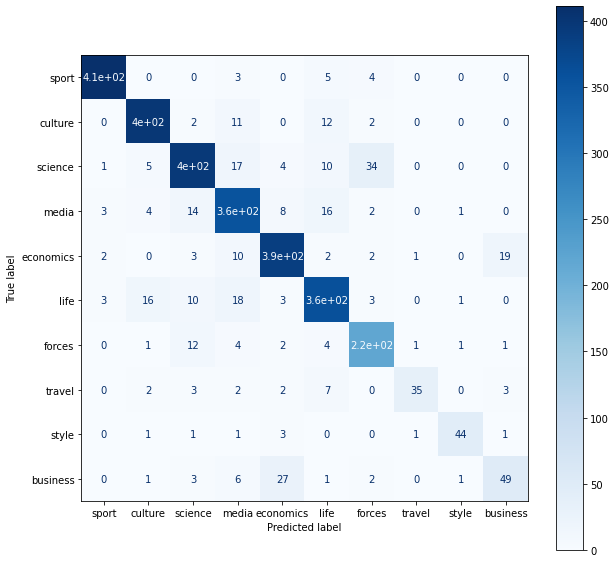

accuracy = 0.885
F1 score = 0.8840470219891619


In [220]:
#SVM
score_test(y_test,svm.predict(X_test))

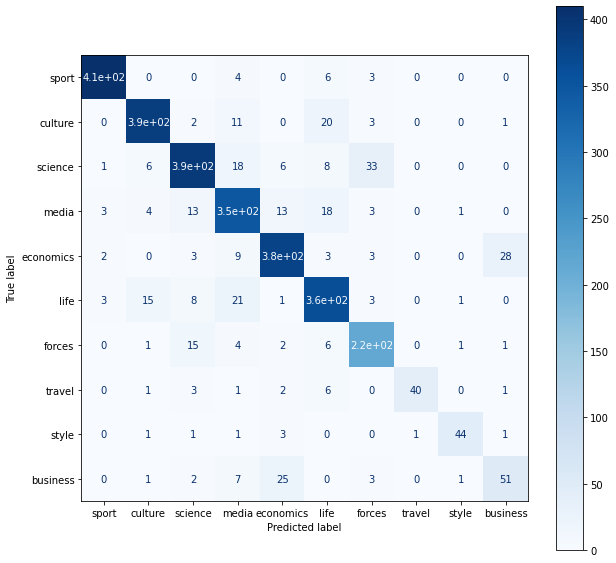

accuracy = 0.8773333333333333
F1 score = 0.8773032251007428


In [219]:
#LOGICSTIC REG
score_test(y_test,log_reg.predict(X_test))